In [1]:
from datetime import datetime
from IPython.display import display, clear_output
#import graphviz 
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import gridspec
from matplotlib.ticker import MaxNLocator
import numpy as np
import os
import pandas as pd
import pickle as pkl
import textwrap
import time

#from bonsai_bp.helpers import commons

plt.style.use('material')

rgba = 50
hexa = str(hex(rgba))[2:]
colors = {
    'Identity':     {'pos':0,'hex':'#ff000000','hexa':'#ff0000'+hexa,'rgb':(255,0,0,255),   'rgba':[255,0,0]+[rgba]}, 
    'Max_Pool_3x3': {'pos':1,'hex':'#0000ff00','hexa':'#0000ff'+hexa,'rgb':(0,0,255,255),   'rgba':[0,0,255]+[rgba]}, 
    'Conv_1x1':     {'pos':2,'hex':'#ffc00000','hexa':'#ffc000'+hexa,'rgb':(255,192,0,255), 'rgba':[255,192,0]+[rgba]}, 
    'Sep_Conv_3x3': {'pos':3,'hex':'#96169600','hexa':'#961696'+hexa,'rgb':(150,22,150,255),'rgba':[150,22,150]+[rgba]},
    'Zero':         {'pos':4,'hex':'#ffffff00','hexa':'#ffffff'+hexa,'rgb':(255,255,255,255),'rgba':[255,255,255]+[rgba]}
}

In [2]:
def node_remap(node):
    if node=='x':
        return 0
    elif node=='y':
        return 1
    else:
        return int(node)+2

# Process Genotype

In [138]:
g_viz = False

def process(name):
    params, genotype = pkl.load(open('genotypes/{}_np.pkl'.format(name),"rb"))
    cell_types = []

    op_counts = []
    if g_viz:
        p = graphviz.Digraph(name='parent')
        p.attr('node',shape='circle',size='1,2')
        p.edge('input','0_x')
        p.edge('input','0_y')
        p.edge('input','1_y')
    n = params['nodes']+2

    cells = []
    cell_types = {k:v for k,v in enumerate([(cell,i,j) for i,pattern in enumerate(params['patterns']) for j,cell in enumerate(pattern)])}
                  
    for i,(cell_name, cell_genotype) in enumerate(genotype.items()):
        cell_type = cell_types[cell_name][0].upper()
        op_count = {k:0 for k in colors.keys()}
        if cell_genotype['Y'].get('weights'):
            ys = [x.item() for x in cell_genotype['Y']['weights']]
        else:
            ys = [-1 if x else 1  for x  in cell_genotype['Y']['zeros']]
        cell = {'name':'Cell {} ({})'.format(i,cell_type),
                'pos':cell_types[cell_name][1:],
                'X':i-1 if i else 'In',
                'Y':[i-1 if i else 'In' for i,val in enumerate(ys) if val>0]}
        if g_viz:
            g = graphviz.Digraph()
            g.attr(label='{} ({})'.format(cell_name,cell_types[i]))
            g.attr('node',shape='circle')
        for key,val in cell_genotype.items():
            for v in val:
                if type(v) is not str:
                    weight = v[1] if type(v[1]) is int else v[1].item()
                    if key is not 'X' and key is not 'Y':
                        origin_node,target_node = key.split("->")
                        origin = '{}_{}'.format(cell_name,origin_node)
                        target = '{}_{}'.format(cell_name,target_node)

                        o,t = node_remap(origin_node),node_remap(target_node)
                        if cell.get(o) is None:
                            cell[o] = {}
                        if cell[o].get(t) is None:
                            cell[o][t]=[None]*len(colors.keys())

                        if cell_type=='R' and o<=1 and v[0]=='Identity':
                            op = 'Max_Pool_3x3' 
                            op_pos = colors['Identity']['pos']
                        else:
                            op = v[0]
                            op_pos = colors[op]['pos']
                        if weight>0:
                            cell[o][t][op_pos]=colors[op]['rgb']
                            if g_viz:
                                g.edge(origin, target, color=colors[op]['hex'])
                        elif weight<=0:
                            cell[o][t][op_pos]=colors[op]['rgba']
                            if g_viz:
                                g.edge(origin, target, color=colors[op]['hexa'])    

                        op_count[op]+=1
        cells.append(cell)
        if g_viz:
            p.subgraph(g)
            if i<len(genotype.items())-1:
                p.edge(target,'{}_x'.format(cell_name+1,cell_types[i+1]))
                p.edge(target,'{}_y'.format(cell_name+2,cell_types[i+1])) 
        op_count['cell_type']=cell_type
        op_counts.append(op_count)
    #p.view()
    op_counts = pd.DataFrame(op_counts)
    return params, op_counts,cells,n

# Cell Visualization

## Code

In [140]:
def plot_pixel(pixel,size):
    out = np.zeros([size,size,4])
    for i in range(size):
        for j in range(size):
            if i<size//2 and j<size//2 and pixel[0] is not None:
                out[i,j]=pixel[0]
            elif i>=size//2 and j<size//2 and pixel[1] is not None:
                out[i,j]=pixel[1]
            elif i<size//2 and j>=size//2 and pixel[2] is not None:
                out[i,j]=pixel[2]
            elif i>=size//2 and j>=size//2 and pixel[3] is not None:
                out[i,j]=pixel[3]
    return out

In [141]:
def plot_cell(cell, n, ax):
    size = 12
    out = np.zeros((n*size,n*size,4),dtype=int)
    ax.axis('off')
    if cell is not None:
        ax.axis('on')
        for i in range(out.shape[0]):
            for j in range(out.shape[1]):
                out[i,j]=(255,255,255,255)
        for i,v in cell.items():
            if i not in ['name','pos','X','Y']:
                for j in v.keys():
                    if j>i and not (i==0 and j==1):
                        out[(i*size):(i*size+size),(j*size):(j*size+size)]=plot_pixel(cell[i][j],size)       
                        
    im = ax.imshow(out);
    fontsize = 12
    if cell is not None:
        x_str = str(cell['X']).replace("'","").replace("[",'').replace("]",'')
        y_str = str(cell['Y']).replace("'","").replace("[",'').replace("]",'')
        text_str = "X: {}\n\nY: {}".format(textwrap.fill(x_str,20),textwrap.fill(y_str,20))
        ax.text(0.05, 0.95, text_str, fontsize=fontsize, color='k',verticalalignment='top')
        ax.set_title(cell['name'],fontsize=fontsize*1.2)
    
    # Major ticks
    ax.set_xticks(np.arange(size/2-.5, n*size, size));
    ax.set_yticks(np.arange(size/2-.5, n*size, size));

    # Labels for major ticks
    ax.set_xticklabels(np.arange(0, n, 1), fontsize=fontsize);
    ax.set_yticklabels(np.arange(0, n, 1), fontsize=fontsize);

    # Minor ticks
    ax.set_xticks(np.arange(-.5, n*size, size), minor=True);
    ax.set_yticks(np.arange(-.5, n*size, size), minor=True);

    # Gridlines based on minor ticks\
    ax.grid(which='major', b=False)
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

## Vis

Updated at 12/05/2019, 17:46:54


IndexError: index 4 is out of bounds for axis 1 with size 4

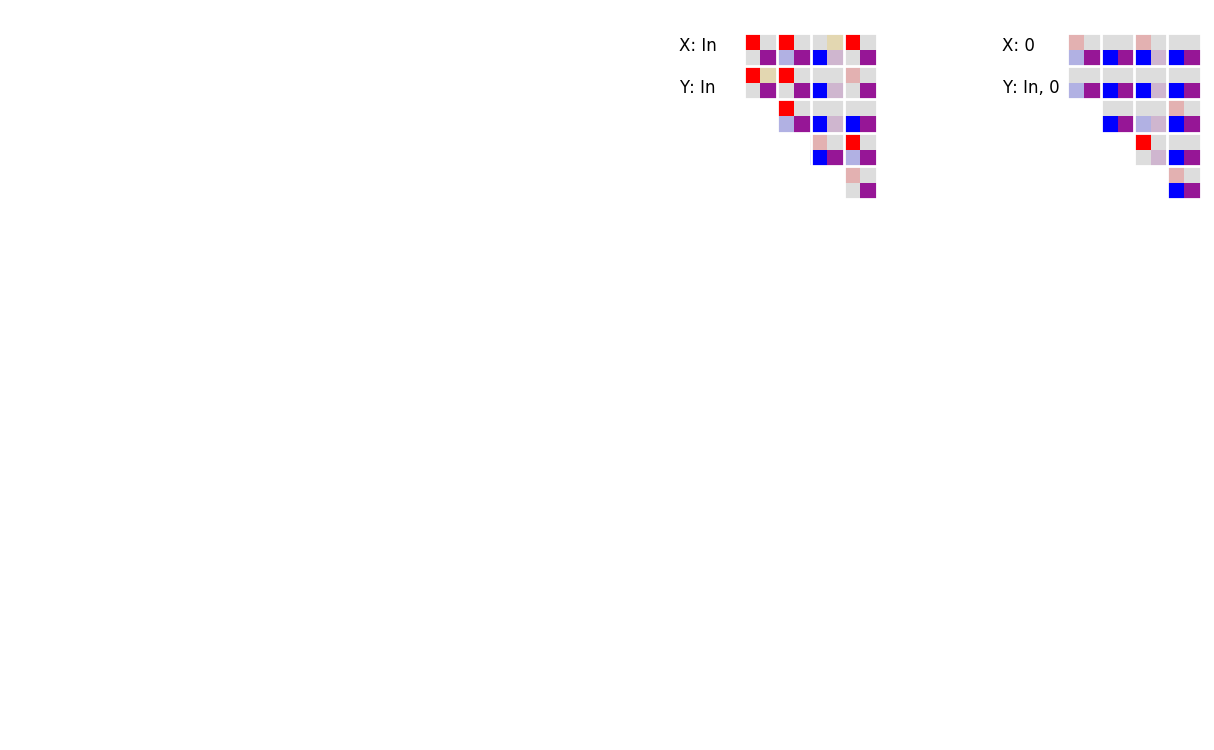

In [151]:
# path = os.getcwd()+"/genotypes"
target = max([(file,os.stat(path+"/"+file).st_mtime) for file in os.listdir(path)],key=lambda x: x[1])[0]
target = target.replace("_np.pkl","").replace(".pkl","")

while 1:
    file_mod = os.stat('genotypes/{}.pkl'.format(target)).st_mtime
    clear_output()
    try:
        print("Updated at",datetime.now().strftime("%m/%d/%Y, %H:%M:%S"))
        params, op_counts, cells, n = process(target) 
        dim = max([cell['pos'][0] for cell in cells]),max([cell['pos'][1] for cell in cells])
        offset = [dim[0]-cell['pos'][0] for cell in cells]
        size = 5
        fig, axes = plt.subplots(dim[0]+1,
                                 dim[1]+1,
                                 figsize=(16,9),
                                 dpi=100)
        for a in [col for row in axes for col in row]:
            plot_cell(None,n,a)
        for i,cell in enumerate(cells):
            plot_cell(cell,n,axes[cell['pos'][0],offset[i]+cell['pos'][1]])
        plt.tight_layout()
        plt.show()
    except (EOFError, pkl.UnpicklingError) as e:
        time.sleep(1)
        continue
    except Exception as e:
        raise e
    while file_mod == os.stat('genotypes/{}.pkl'.format(target)).st_mtime:
        time.sleep(1)